# Nanodegree Engenheiro de Machine Learning

## Capstone Project

Este projeto consiste em classificar em uma base histórica de um site de leilões os lances realizados de forma automatizada (feita por robôs) e aqueles feitos pelos usuários tradicionais (humanos).

In [1]:
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

## Importando os dados

Abaixo vamos importar as bases de treino e lances, em seguida faremos o merge entre elas.

In [2]:
train = pd.read_csv('../input/train.csv')
train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [3]:
bids = pd.read_csv('../input/bids.csv')
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [4]:
train_bids = pd.merge(bids, train, how='left', on='bidder_id')
train_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,payment_account,address,outcome
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3,NaN,NaN,NaN
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,a3d2de7675556553a5f08e4c88d2c228ucoac,42a3b61a1fe69d66ad60f3e347aa09b1erfe2,0.0
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3,NaN,NaN,NaN
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3,NaN,NaN,NaN
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3,NaN,NaN,NaN


Na célula abaixo são removidos os registros onde não constam a variável resposta *outcome* e a variável *country*. Esta abordagem foi adotada em preferência a preencher estes valores faltantes para não criar distorções no dataset.

In [5]:
train_bids.dropna(subset=['outcome'], inplace=True)
train_bids.dropna(subset=['country'], inplace=True)
train_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,payment_account,address,outcome
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c,a3d2de7675556553a5f08e4c88d2c228ucoac,42a3b61a1fe69d66ad60f3e347aa09b1erfe2,0.0
5,5,e8291466de91b0eb4e1515143c7f74dexy2yr,3vi4t,mobile,phone7,9759243157894736,ru,91.107.221.27,vasstdc27m7nks3,2c198811bf76f74512e24f5a537e21f9o3kyh,4e408da3d4dc783220f7d7c6a2f6bb62fxl68,0.0
9,9,a58ace8b671a7531c88814bc86b2a34cf0crb,3zpkj,sporting goods,phone4,9759243210526315,za,123.28.123.226,vasstdc27m7nks3,a3d2de7675556553a5f08e4c88d2c22817wsw,a3d2de7675556553a5f08e4c88d2c228qg5i2,0.0
10,10,a58ace8b671a7531c88814bc86b2a34cf0crb,z6j8b,sporting goods,phone10,9759243210526315,ng,209.80.85.101,adgjz71s3p2oiau,a3d2de7675556553a5f08e4c88d2c22817wsw,a3d2de7675556553a5f08e4c88d2c228qg5i2,0.0
13,13,7e34a26c4c339e875997f4b9239d2b5fscng4,nbx39,mobile,phone13,9759243263157894,in,143.183.225.33,e5i17pk9wygxewv,d1154cf7f47d7be0579cf24f6df1edcaagi99,fe7698870c64030109477f0d692741bfb3jn2,0.0


In [6]:
train_bids.describe(include='all')

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,payment_account,address,outcome
count,3.068523e+06,3068523,3068523,3068523,3068523,3.068523e+06,3068523,3068523,3068523,3068523,3068523,3.068523e+06
unique,NaN,1983,12740,10,5726,NaN,198,1028810,663265,1983,1983,NaN
top,NaN,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,jqx39,sporting goods,phone4,NaN,in,224.130.156.216,vasstdc27m7nks3,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,NaN
freq,NaN,515032,216675,1169328,306994,NaN,645631,37659,1545585,515032,515032,NaN
mean,3.838034e+06,NaN,NaN,NaN,NaN,9.696610e+15,NaN,NaN,NaN,NaN,NaN,1.343164e-01
std,2.191871e+06,NaN,NaN,NaN,NaN,5.256733e+13,NaN,NaN,NaN,NaN,NaN,3.409920e-01
min,1.000000e+00,NaN,NaN,NaN,NaN,9.631917e+15,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,1.945638e+06,NaN,NaN,NaN,NaN,9.640958e+15,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,3.835838e+06,NaN,NaN,NaN,NaN,9.700339e+15,NaN,NaN,NaN,NaN,NaN,0.000000e+00
75%,5.707098e+06,NaN,NaN,NaN,NaN,9.761309e+15,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [7]:
del train
del bids

Abaixo confirmamos a proporção do desbalanceamento do dataset. Apenas 13,4% dos lances foram feitos por robôs.

   outcome     bid_id
0      0.0  86.568359
1      1.0  13.431641


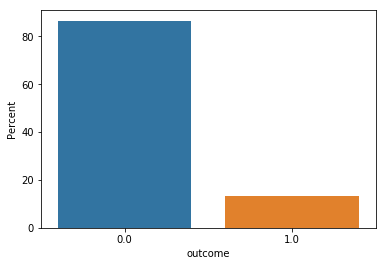

In [8]:
to_plot = train_bids.groupby('outcome')['bid_id'].count()
to_plot = to_plot.groupby(level=0).apply(lambda x: 100 * x / train_bids.shape[0]).reset_index()
print(to_plot)
ax = sns.barplot(x="outcome", y="bid_id", data=to_plot);
ax.set(ylabel="Percent");

Abaixo vemos as proporções de lances feitos por usuários e robôs por cada categoria de produto leiloado indicando que esta pode ser uma variável importante para o modelo.

Outras visualizações foram geradas mas as mesmas não agregaram mais entendimento dos dados e por isso foram removidas.

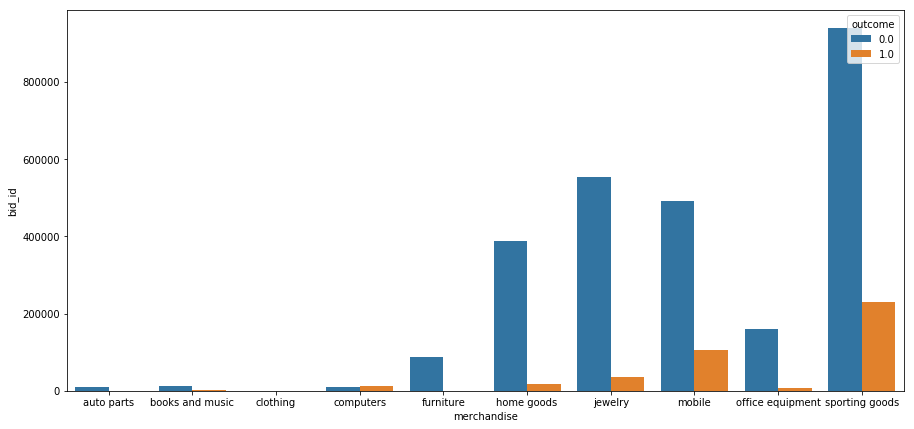

In [9]:
to_plot = train_bids.groupby(['outcome', 'merchandise'])['bid_id'].count()
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(x='merchandise', y='bid_id', hue='outcome', data=to_plot.reset_index(), ax=ax);

Abaixo vamos preparar os dados categóricos da base para alimentar um modelo de árvore de decisão que nos ajudará a entender a importancia de cada variável na categorização dos lances. Usaremos a classe *LabelEncoder* do pacote *scikit-learn* para isso.

In [10]:
X = train_bids.copy()
X.drop(['bid_id', 'outcome', 'time'], axis=1, inplace=True)

d = defaultdict(LabelEncoder)
X = X.apply(lambda x: d[x.name].fit_transform(x))
X.head()

,bidder_id,auction,merchandise,device,country,ip,url,payment_account,address
1,796,3645,4,1,84,813216,361821,1497,438
5,1803,1317,7,5212,154,992702,576774,153,522
9,1295,1354,9,3089,194,114979,576774,649,1288
10,1295,12435,9,2,132,497796,191118,649,1288
13,985,8288,7,331,84,202110,261143,1811,1979


Abaixo faremos o ajuste da variável alvo e separaremos o dataset em conjuntos de treino e teste. Usaremos o conjunto de teste para avaliar o modelo gerado.

In [11]:
y = np.ravel(train_bids.outcome)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Abaixo vamos confirmar se os conjuntos de treino e teste preservaram as proporções do dataset original

In [13]:
from __future__ import division
from collections import Counter

print("treino")
x = Counter(y_train)
print(x[0.0]/len(y_train))
print(x[1.0]/len(y_train))

print("teste")
x = Counter(y_test)
print(x[0.0]/len(y_test))
print(x[1.0]/len(y_test))

treino
0.865797223978
0.134202776022
teste
0.865418436881
0.134581563119


Abaixo será feito o treino do modelo de árvore de decisão. Este modelo nos dirá a importância de cada variável do dataset e será usado para uma primeira avaliação da nossa capacidade de classificação.

In [14]:
forest = ExtraTreesClassifier(
    n_estimators=250,
    criterion="entropy",
    min_samples_split=30,
    max_depth=10,
    random_state=42,
    n_jobs=4)
forest.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=10, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Abaixo são mostradas as variáveis e suas importâncias em uma visualização em barras. As variáveis *address*, *bidder_id*, *payment_account* e *merchandise* foram identificadas como as mais importantes para o modelo.

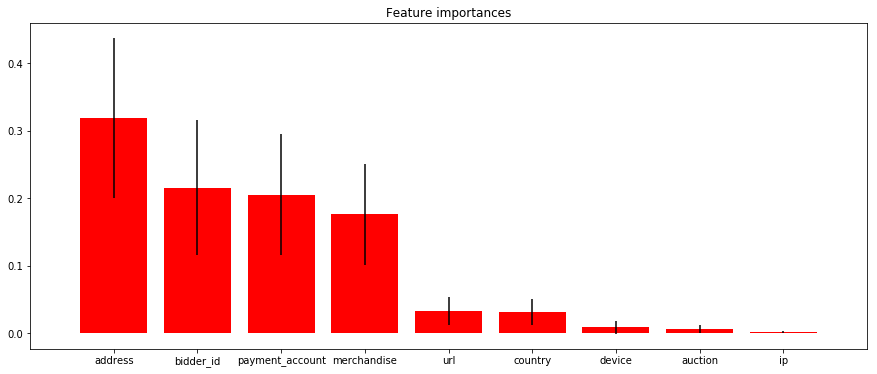

In [15]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = [X.columns[i] for i in indices]

plt.figure(figsize=(15,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names)
plt.xlim([-1, X.shape[1]])
plt.show()

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Abaixo o modelo de árvore de decisão é testado usando matriz de confusão, precision score e recall score.

Normalized confusion matrix
[[ 1.     0.   ]
 [ 0.284  0.716]]


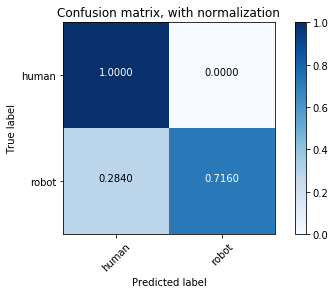

In [17]:
class_names = ['human', 'robot']
y_pred = forest.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=4)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')


In [18]:
y_scores = forest.predict_proba(X_test)[:,1]

print("Precision Score: %s" % precision_score(y_test, y_pred))
print("Recall Score: %s" % recall_score(y_test, y_pred))
print("ROC AUC Score: %s" % roc_auc_score(y_test, y_scores))

Precision Score: 1.0
Recall Score: 0.716006134474
ROC AUC Score: 0.999261329539


Abaixo faremos a plotagem da curva ROC que é usada no desafio como método de avaliação

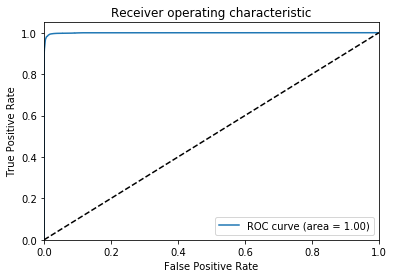

In [19]:
from sklearn.metrics import roc_curve, auc

# ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Aparentemente o modelo treinado para nos informar as variáveis mais importantes para o modelo conseguiu um bom desempenho e poderia ser usado para classificar os lances, mas ao submeter os resultados obtidos à competição na plataforma Kaggle o score obtido foi de 50,7%

![kaggle](kaggle.png)

---
### Ajuste no dataset

Com base no modelo de arvore de decisão que nos mostrou as features mais importantes, vamos remover as colunas `ip`, `auction` e `device` que contribuem menos para a classificação dos lances. Após a deleção destas colunas os conjuntos de treinamento e teste são atualizados

In [20]:
X = X.drop(['ip', 'auction', 'device'], axis=1)
X.head()

,bidder_id,merchandise,country,url,payment_account,address
1,796,4,84,361821,1497,438
5,1803,7,154,576774,153,522
9,1295,9,194,576774,649,1288
10,1295,9,132,191118,649,1288
13,985,7,84,261143,1811,1979


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Como sugerido na proposta de projeto, vamos comparar o desempenho deste modelo treinado com um classificador "Dummy".

Normalized confusion matrix
[[ 0.8655  0.1345]
 [ 0.866   0.134 ]]


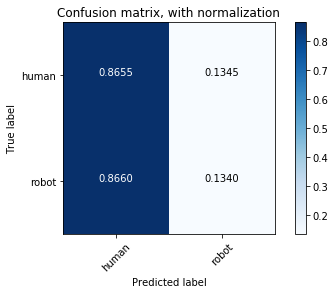

In [22]:
dummy = DummyClassifier(random_state=42)
dummy.fit(X_train, y_train)
dummy_predict = dummy.predict(X_test)

class_names = ['human', 'robot']
cnf_matrix = confusion_matrix(y_test, dummy_predict)
np.set_printoptions(precision=4)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')


In [23]:
print("Precision Score: %s" % precision_score(y_test, dummy_predict))
print("Recall Score: %s" % recall_score(y_test, dummy_predict))
print("ROC AUC Score: %s" % roc_auc_score(y_test, dummy_predict))

Precision Score: 0.134184193084
Recall Score: 0.133997901364
ROC AUC Score: 0.499770736133


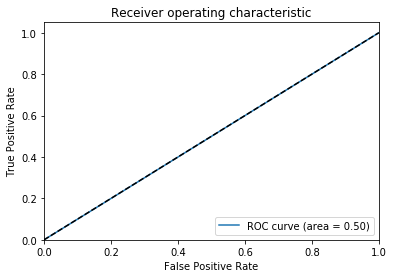

In [24]:
y_scores = dummy.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Os testes feitos até aqui reaproveitaram um modelo que foi treinado com o objetivo de avaliar as features disponíveis. Vamos agora treinar outros algoritmos para vermos os resultados.

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [26]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3, n_jobs=4),
    SVC(kernel="linear", C=0.025, class_weight=[{0.0:0.86, 1.0:0.13}]),
    SVC(gamma=2, C=1, class_weight=[{0.0:0.86, 1.0:0.13}]),
    GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=4),
    DecisionTreeClassifier(max_depth=5, class_weight=[{0.0:0.86, 1.0:0.13}]),
    RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=4),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [27]:
results = []
for name, clf in zip(names, classifiers):
    print(name)
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_scores = clf.predict_proba(X_test)[:,1]
    except:
        print "Could not train %s model" % name
        continue
 
    results.append({
        'name': name,
        'precision': precision_score(y_test, y_pred),
        'recal': recall_score(y_test, y_pred),
        'ROC score': roc_auc_score(y_test, y_scores)
    }) 


Nearest Neighbors
Linear SVM
Could not train Linear SVM model
RBF SVM
Could not train RBF SVM model
Gaussian Process
Could not train Gaussian Process model
Decision Tree
Could not train Decision Tree model
Random Forest
Neural Net


/home/rafael/prj/udacity/mlnd/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AdaBoost
Naive Bayes
QDA


## Checkpoint

Salvandos os dados para poder prosseguir daqui.

In [1]:
import pickle

with open('../input/train_test.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

with open('../input/results.pkl', 'wb') as f:
    pickle.dump(results, f)

NameError: name 'X_train' is not defined

Carregando os dados

In [3]:
import pickle
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline

with open('../input/train_test.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

with open('../input/results.pkl', 'rb') as f:
    results = pickle.load(f)

EOFError: 

In [30]:
results = pd.DataFrame(results)
results = results.set_index('name')

In [32]:
results['mean'] = results.mean(axis=1)
results.sort_values('mean')

,ROC score,precision,recal,mean
name,,,,
Neural Net,0.501279,0.000000,0.000000,0.167093
Naive Bayes,0.763995,0.994088,0.203576,0.653886
QDA,0.825217,0.811563,0.413229,0.683336
AdaBoost,0.975941,0.933923,0.664541,0.858135
Random Forest,0.980678,0.995836,0.606078,0.860864
Nearest Neighbors,0.984086,0.963305,0.939123,0.962172


Com os parâmetros usados (com poucas alterações), os algorítmos Nearest Neighbors e Random Forest apresentaram as melhores médias entre o ROC Score, Precision e Recall. O modelo escolhido será Nearest Neighbors pois o mesmo apresentou o melhor Recall entre os modelos testados. Vamos agora para a otimização dos parâmetros com Nearest Neighbors.

In [40]:
params = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['brute', 'ball_tree', 'kd_tree'],
    'p':[1, 2]
}

model = KNeighborsClassifier()
clf = GridSearchCV(model, params, n_jobs=1)
clf.fit(X_train, y_train)

MemoryError: 

In [11]:
clf.cv_results_['rank_test_score']

array([52, 52, 52, 31, 31, 52, 52, 31, 31, 31, 31, 31, 31, 31, 31, 52, 31,
       31, 31, 31, 52, 50, 50, 27, 26, 31, 30, 16, 10,  5, 52, 31, 31, 28,
       28, 52, 31, 20, 20, 20, 31, 19, 17, 14, 11, 24, 18, 12,  7,  6, 25,
       15,  9,  4,  3, 20, 13,  8,  2,  1], dtype=int32)

In [16]:
y_pred = clf.predict(X_test)
y_scores = clf.predict_proba(X_test)[:,1]

print 'precision', precision_score(y_test, y_pred)
print 'recal', recall_score(y_test, y_pred)
print 'ROC score', roc_auc_score(y_test, y_scores)

 precision 0.961842929552
recal 0.817935265155
ROC score 0.992906440317


Com o modelo obtido pelo Grid Search não só conseguimos ótimas pontuações de ROC e Precision mas melhoramos muito a pontuação de Recall (de 66% para 81%), o que ajuda a concluir que este seria o modelo ideal.

## Salvando o modelo treinado

In [18]:
with open('../input/results.pkl', 'wb') as f:
    pickle.dump(results, f)